# Assignment #7

In the United States, soils are classified using the [USDA soil taxonomy](https://www.nrcs.usda.gov/Internet/FSE_DOCUMENTS/nrcs142p2_051232.pdf). Within the USDA soil taxonomy, the most general level is the taxonomic order. In this assignment we will be using a suite of decision-tree based classification algorithms to create spatial maps of taxonomic order over western Illinois. The point observations come from the [NASIS database](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/tools/?cid=nrcs142p2_053552) while the environmental predictors come from Sentinel 2, the National Elevation Data, and the National Land Cover database.

For this homework, all the data have already been subsetted and preprocessed and are compiled in the following NetCDF file `/data/HW/HW7.nc`. The file is split into two groups: predictors and observations. The predictors group contains a set of 1 arcsec maps for the domain and the observations group contains the in-situ taxonomic order observations with their associated geographic coordinates. Although not required, we recommend using xarray to read in these data. 

# 1. Environmental predictors (5 pts)

Read in and create maps of all the predictors. Describe any apparent discrepancies in scale between the maps.

In [1]:
import netCDF4 as nc
import numpy as np

file = '/data/HW/HW7.nc'
fp = nc.Dataset(file)

In [2]:
#import xarray as xr

#datapred = xr.open_dataset('/data/HW/HW7.nc', group = 'predictors')
#dataobserv = xr.open_dataset('/data/HW/HW7.nc', group = 'observations')

In [3]:
vars = ['elevation','ndvi','evi','red','green','blue','tree_cover_fraction','gamma_uranium',
        'gamma_thorium','gamma_potassium']
data = {}
for var in vars:
    data[var] = fp['predictors'][var][:]

In [4]:
variable = 'taxonomic_order'
#Bring in the data
test = []
feature_names = []
for var in data:
    if var == variable:continue
    tmp = data[var].reshape(data[var].size)
    test.append(tmp)
    feature_names.append(var)
test = np.array(test).T

1
elevation (1080, 1080)
2
ndvi (1080, 1080)
3
evi (1080, 1080)
4
red (1080, 1080)
5
green (1080, 1080)
6
blue (1080, 1080)
7
tree_cover_fraction (1080, 1080)
8
gamma_uranium (1080, 1080)
9
gamma_thorium (1080, 1080)
10
gamma_potassium (1080, 1080)


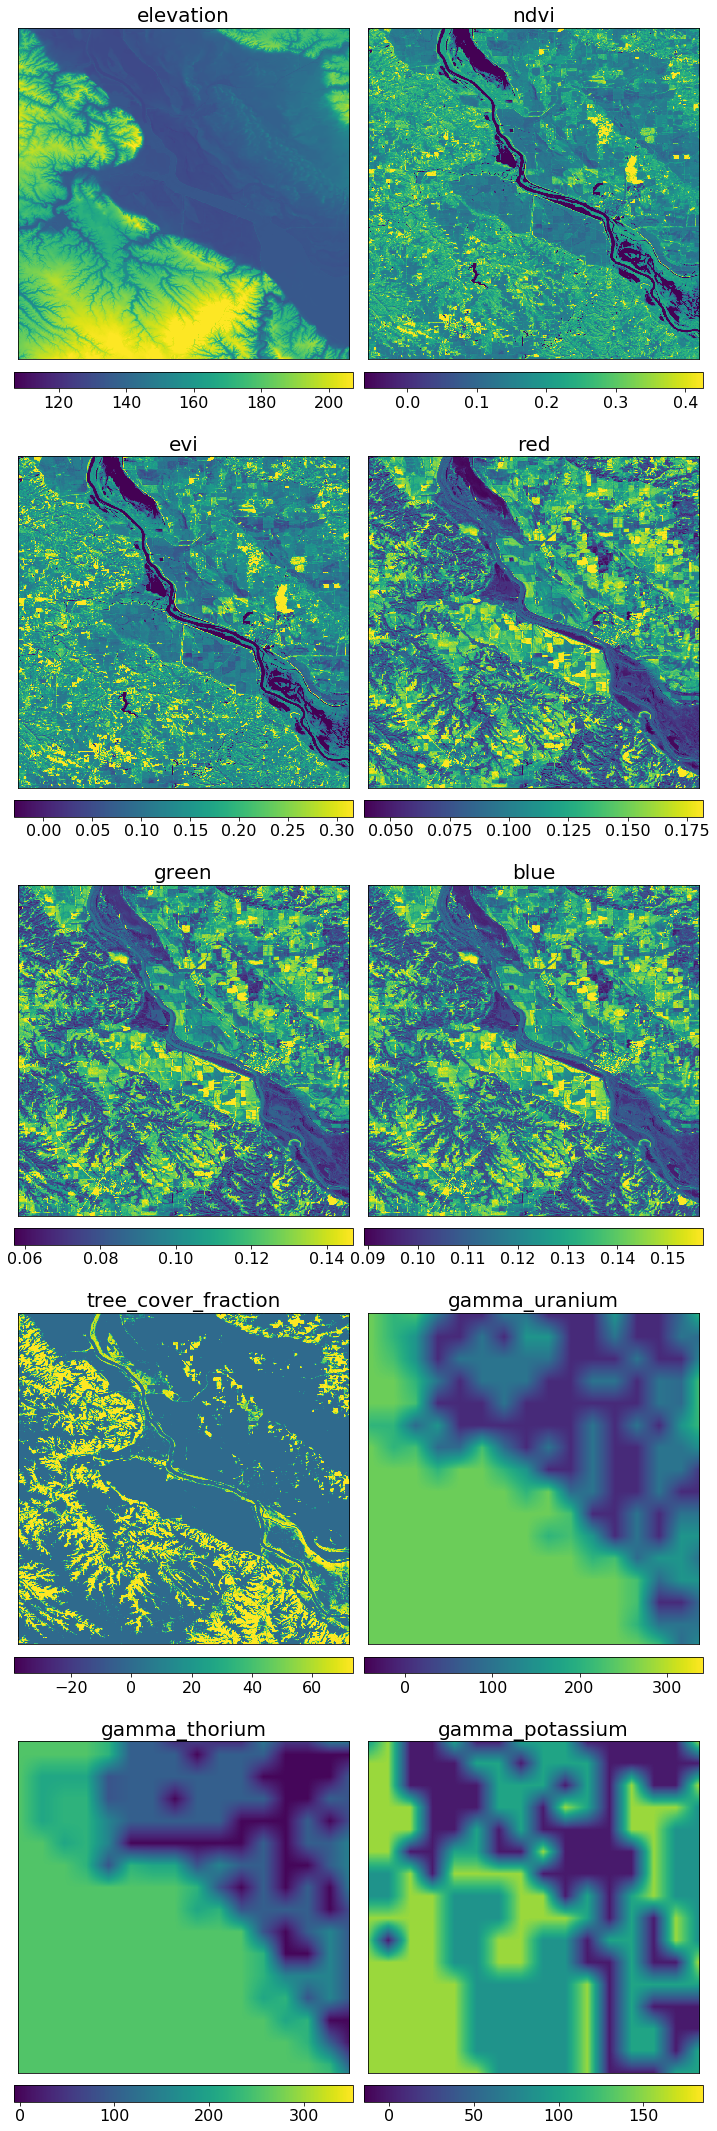

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,30))
i = 0
for var in data:
    i += 1
    print(i)
    print(var,data[var].shape)
    plt.subplot(5,2,i)
    plt.xticks([])
    plt.yticks([])
    vmin = np.mean(data[var]) - 2*np.std(data[var])
    vmax = np.mean(data[var]) + 2*np.std(data[var])
    plt.imshow(data[var], vmin = vmin, vmax = vmax)
    cb = plt.colorbar(orientation='horizontal',pad=0.03)
    cb.ax.tick_params(labelsize=16)
    plt.title(var,fontsize=20)
plt.tight_layout()
plt.show()

In [6]:
print('Conclusion: gamma_uranium, gamma_thorium and gamma_potassiu are apparently different in scale from all the others based on the plots above.')

Conclusion: gamma_uranium, gamma_thorium and gamma_potassiu are apparently different in scale from all the others based on the plots above.


# 2. Extract each site's collocated predictors (5 pts)

Read in the in-situ observations and assemble the corresponding predictors for each site. Finally, create the $\mathbf{X}$ array of predictors and the $\mathbf{y}$ array of observed taxonomic orders. This dataset will be used throughout the rest of the assignment to fit and evaluate the classification algorithms. Note that you will need to convert the taxonomic order names to integers for use in sklearn.

In [7]:
#'mollisols: 0''entisols: 1''alfisols: 2''inceptisols: 3'
temp = []
for thing in fp['observations']['taxonomic_order'][:]:
    if thing == 'mollisols':
        temp.append(0)
    if thing == 'entisols':
        temp.append(1)
    if thing == 'alfisols':
        temp.append(2)
    if thing == 'inceptisols':
        temp.append(3)
temp = np.array(temp)
data['taxonomic_order'] = temp[:]

In [8]:
latsobserv = fp['observations']['lat'][:].reshape(153)
lonsobserv = fp['observations']['lon'][:].reshape(153)
coordobserv = np.stack((latsobserv, lonsobserv)).T

In [9]:
latspred = fp['predictors']['lat'][:].reshape(1080)
lonspred = fp['predictors']['lon'][:].reshape(1080)

In [10]:
index = []
for thing in coordobserv:
    temp = []
    lattemp = []
    lontemp = []
    for i in range(len(latspred)):
        lattemp.append(np.abs(thing[0]-latspred[i]))
    for j in range(len(lonspred)):
        lontemp.append(np.abs(thing[1]-lonspred[j]))
    temp.append(lattemp.index(np.min(lattemp)))
    temp.append(lontemp.index(np.min(lontemp)))
    index.append(temp)
index = np.array(index)

In [11]:
latindex = index[:, 0]
lonindex = index[:, 1]
vars = ['elevation','ndvi','evi','red','green','blue','tree_cover_fraction','gamma_uranium',
        'gamma_thorium','gamma_potassium']
for var in vars:
    temp = []
    for i in range(153):
        temp.append(fp['predictors'][var][latindex[i]][lonindex[i]])
    temp = np.array(temp)    
    data[var] = temp

In [12]:
import sklearn.tree 

variable = 'taxonomic_order'
#Bring in the data
X = []
feature_names = []
for var in data:
    if var == variable:continue
    tmp = data[var].reshape(data[var].size)
    X.append(tmp)
    feature_names.append(var)
X = np.array(X).T
Y = data[variable].reshape(data[variable].size)

In [13]:
print(X)

[[1.45403854e+02 2.26847649e-01 1.71230078e-01 ... 8.70000000e+01
  2.10000000e+01 9.50000000e+01]
 [1.30392471e+02 1.15700625e-01 7.76545480e-02 ... 1.28000000e+02
  2.55000000e+02 1.00000000e+01]
 [1.33486664e+02 1.76419348e-01 1.34684145e-01 ... 1.02000000e+02
  4.30000000e+01 9.90000000e+01]
 ...
 [1.35725525e+02 1.48660481e-01 1.21551976e-01 ... 5.40000000e+01
  7.90000000e+01 0.00000000e+00]
 [1.72224991e+02 1.39325857e-01 1.16447560e-01 ... 2.55000000e+02
  2.55000000e+02 9.60000000e+01]
 [1.39043854e+02 1.39218614e-01 1.16771281e-01 ... 1.14000000e+02
  2.15000000e+02 3.00000000e+00]]


# 3. Fit and evaluate a decision tree (10 pts)

Use the validation set approach to divide your data into training and test datasets. Each dataset should contain 50% of the data. Then fit a Decision tree using the training data and evaluate its accuracy for both the training and test datasets. Explain the differences in accuracy when evaluating the training and test datasets. To ensure reproduceability, when initializing the decision tree, set the random_state to 1.

In [14]:
import sklearn.tree
import sklearn.model_selection

#Split into training and validation
(Xt,Xv,yt,yv) = sklearn.model_selection.train_test_split(X,Y,train_size=0.5,random_state=1)
#Decision tree
clf = sklearn.tree.DecisionTreeRegressor(random_state=1)
#Fit the tree
clf = clf.fit(Xt,yt)
#Determine the accuracy when using the training dataset
print('Training dataset: %f' % clf.score(Xt,yt))
#Determine the accuracy when using the test dataset
print('Test data: %f' % clf.score(Xv,yv))

Training dataset: 0.957799
Test data: 0.053033


# 4. Perform 10-fold cross validation (10 pts)

Using  all the site data, perform a 10-fold cross validation of the decision tree and compare the results to the previous exercise. Set random_state to 1 and set shuffle to True.

In [15]:
import sklearn.tree
import sklearn.ensemble
import sklearn.model_selection

#Define the kfolds
kf = sklearn.model_selection.KFold(n_splits=10,shuffle=True,random_state=1)
#Decision tree
clf = sklearn.tree.DecisionTreeRegressor(random_state=1)
scores = sklearn.model_selection.cross_val_score(clf,X,Y,cv=kf)
print('Decision tree: %f' % np.mean(scores))

Decision tree: 0.093726


# 5. Moving to ensemble tree methods (10 pts)

Setting the number of decision trees to 100, perform a 10-fold cross validation using Bagging, Random Forests, and Gradient Boosting. Discuss how the results of these different ensemble methods vary amongst themselves. Also compare the results to those obtained from a single decision tree. Remember to set random_state to 1 and shuffle to True.

In [16]:
#Define the kfolds
kf = sklearn.model_selection.KFold(n_splits=10,shuffle=True,random_state=1)
#Bagging
clf = sklearn.ensemble.BaggingRegressor(n_estimators=100,random_state=1)
scores = sklearn.model_selection.cross_val_score(clf,X,Y,cv=kf)
print('Bagging: %f' % np.mean(scores))
#Random Forests
clf = sklearn.ensemble.RandomForestRegressor(n_estimators=100,random_state=1)
scores = sklearn.model_selection.cross_val_score(clf,X,Y,cv=kf)
print('Random Forest: %f' % np.mean(scores))
#Gradient Boosting
clf = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100,random_state=1)
scores = sklearn.model_selection.cross_val_score(clf,X,Y,cv=kf)
print('Gradient Boosting: %f' % np.mean(scores))

Bagging: 0.547415
Random Forest: 0.550548
Gradient Boosting: 0.513323


# 6. Out of bag score (10 pts)

Using 100 trees, fit a Random Forest to the entire sites dataset and report the out of bag score. Compare that result to that obtained from the cross validation. Explain what the out of bag score is and how it can be more useful than cross validation. Remember to set random_state to 1.

In [17]:
#Define the statistical method we want to use
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,oob_score=True,random_state=1)
#Initialize the bagging object with the define based estimator and number of trees to use (n_estimators)
#Tell it to compute the out of bag estimate
#Fit the bagging classifier
clf.fit(X,Y)
#Print out of bag estimate of accuracy
print(clf.oob_score_)

0.7450980392156863


# 7. Optimal number of trees (10 pts)

Iterate through the number of decision trees varying from 1 to 100 in 1 tree increments. For each iteration, fit a Random Forest and append the corresponding out of bag score to a list. Plot the out of bag score as a function of the number of decision trees. What do you learn about the optimal number of trees for this problem?

In [18]:
bag_scores = []
for n in range(1, 101):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n,oob_score=True,random_state=1)
    clf.fit(X,Y)
    bag_scores.append(clf.oob_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

52


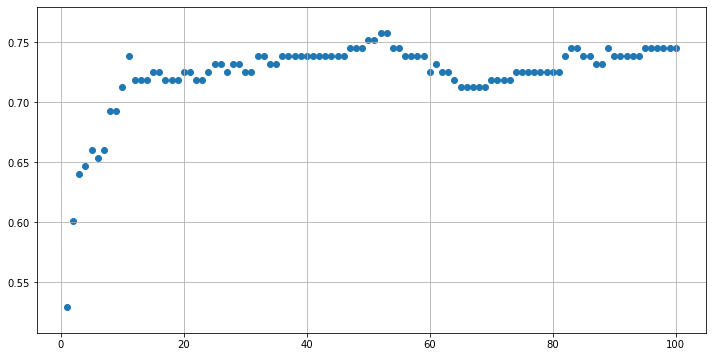

In [31]:
x_axis = []
for n in range(1, 101):
    x_axis.append(n)
plt.figure(figsize=(12,6))
plt.scatter(x_axis[:], bag_scores[:])
print(bag_scores.index(np.max(bag_scores))+1)
plt.grid('on')
plt.show()

In [20]:
print('It can be concluded from the above plot that the optimal number of trees is very important at the range from 0 to 10, but once it gets above 10, the optimal number seems to get to a stable stage.')

It can be concluded from the above plot that the optimal number of trees is very important at the range from 0 to 10, but once it gets above 10, the optimal number seems to get to a stable stage.


In [21]:
print('Conclusion: The optimal number of trees for this problem is 52.')

Conclusion: The optimal number of trees for this problem is 52.


# 8. Plot the predictions (10 pts)

After fitting a random forest with 100 trees, plot a map of the entire region of the predicted taxonomy order.

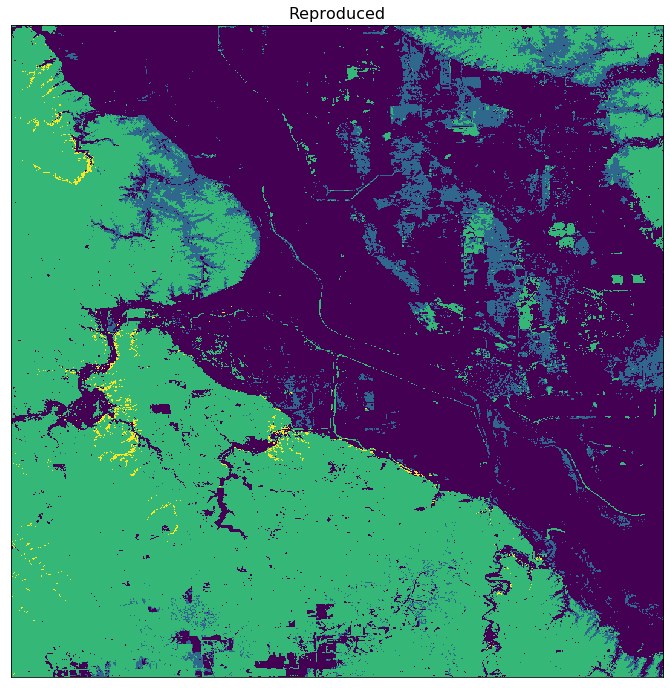

In [22]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,oob_score=True,random_state=1)
clf.fit(X,Y)
plt.figure(figsize=(12,12))
plt.title('Reproduced',fontsize=16)
plt.imshow(clf.predict(test).reshape(1080, 1080))
plt.xticks([])
plt.yticks([])
plt.show()

# 9 Feature importance (10 pts)

Plot the feature importance of the predictors in the previously fitted Random Forest and describe the results.

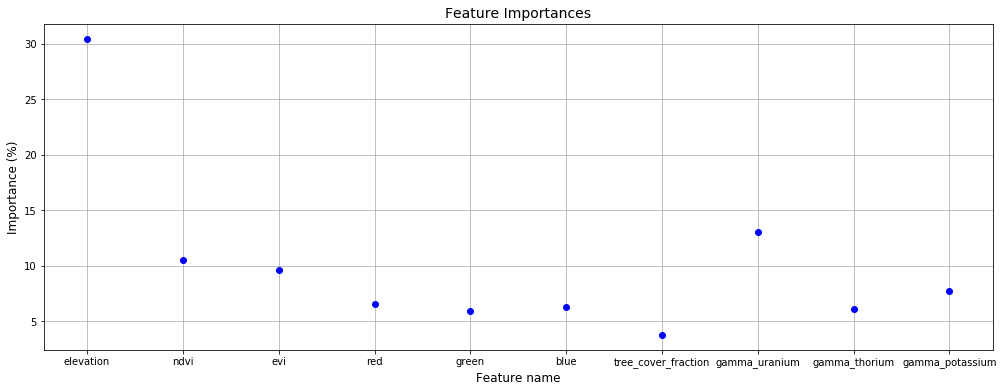

In [23]:
#Define the statistical method we want to use
clf = sklearn.tree.DecisionTreeClassifier(random_state = 1)
#Initialize the bagging object with the define based estimator and number of trees to use (n_estimators)
#Tell it to compute the out of bag estimate
bclf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,oob_score=True, random_state=1)
#Fit the bagging classifier
bclf = bclf.fit(X,Y)
#Print out of the feature importance per variable
temp = bclf.feature_importances_
tmp = []
for thing in temp:
    tmp.append(thing*100)
plt.figure(figsize=(17, 6))
plt.plot(vars, tmp, 'bo')
plt.grid('on')
plt.xlabel('Feature name', fontsize = 12)
plt.ylabel('Importance (%)', fontsize = 12)
plt.title('Feature Importances', fontsize = 14)
plt.show()

In [24]:
print('Elevation seems to be the most weighted parameters, whereas all the others seem to have close importance that is lower than that of elevation.')

Elevation seems to be the most weighted parameters, whereas all the others seem to have close importance that is lower than that of elevation.


# 10. Confidence in the predictions (10 pts)

Assemble the maps of probabilities per taxonomic order from the previously fitted Random Forest. Then for each cell, sort these data from highest to lowest. Finally, for each cell, compute the difference between the highest and second highest probabilities. Plot the map of this difference. What do you learn from this map? What could explain the regions where the difference in probability of the first and second most probable taxonomic orders is low?

In [25]:
for i in range(len(bclf)):
    if i == 0:probs = bclf[i].predict_proba(test)
else:probs += bclf[i].predict_proba(test)
probs = probs/np.sum(probs,axis=1)[:,np.newaxis]
newprobs = np.sort(probs)
#Perform a majority vote by selecting the class with the highest probability
ypred = np.argmax(probs,axis=1)

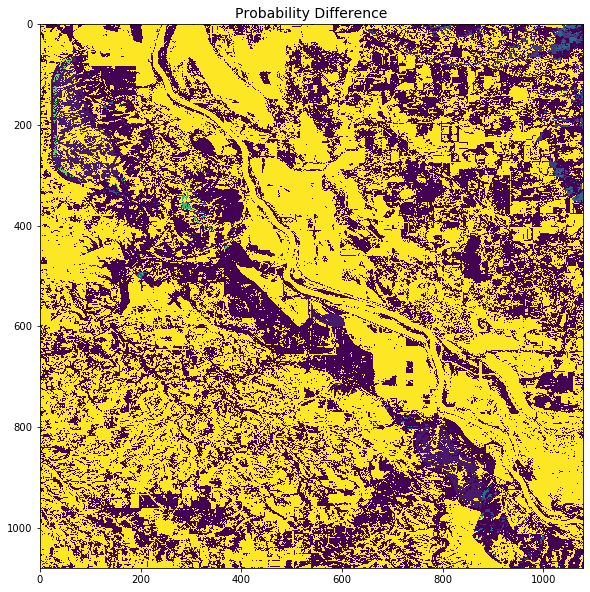

In [26]:
first = newprobs[:,-1]
second = newprobs[:,-2]
diff = first - second
diff = diff.reshape(1080, 1080)
plt.figure(figsize = (10,10))
plt.imshow(diff)
plt.title('Probability Difference', fontsize = 14)
plt.show()

In [27]:
print('I learn from this map that the black regions mean that the differences at those places are zero. Hence it is very likely that the groupings for those places are correct. Whereas the groupings for thoses places in yellow are very likely to be wrong.')
print('The regions that the differences are low basically means that the groupings for those places are very likely correct.')

I learn from this map that the black regions mean that the differences at those places are zero. Hence it is very likely that the groupings for those places are correct. Whereas the groupings for thoses places in yellow are very likely to be wrong.
The regions that the differences are low basically means that the groupings for those places are very likely correct.


# 11. Dimensionality reduction (10 pts)

After standardizing the data, use PCA to reduce the number of predictors of the sites dataset down to 5. What is the total explained variance when considering only the top 5 principal components? Then fit a Random forest to these data with 100 decision trees and report the out of bag score. What does this result tell us about the utility of dimensionality reduction?

In [48]:
import sklearn.decomposition
testpred = (X-np.mean(X, axis=0))/np.std(X, axis=0)
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=5)
#Fit the model
pca.fit(testpred)
testpred = pca.transform(testpred)

In [49]:
print(testpred.shape)

(153, 5)


In [50]:
print('Explained variance:')
print(pca.explained_variance_)
print('Total Explained variance:')
print(sum(pca.explained_variance_))

Explained variance:
[3.634112  2.6550875 1.8596367 0.6389016 0.5696091]
Total Explained variance:
9.357346713542938


In [51]:
#Define the statistical method we want to use
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,oob_score=True,random_state=1)
#Initialize the bagging object with the define based estimator and number of trees to use (n_estimators)
#Tell it to compute the out of bag estimate
#Fit the bagging classifier
clf.fit(testpred,Y)
#Print out of bag estimate of accuracy
print(clf.oob_score_)

0.7254901960784313


In [53]:
print('The out of bag score is lower than before by a small amount, which makes sense because the number of parameters evaluated is reduced. But a small amount indicates that even though the score is lower, it will not be that be of influence.')

The out of bag score is lower than before by a small amount, which makes sense because the number of parameters evaluated is reduced. But a small amount indicates that even though the score is lower, it will not be that be of influence.
